# Capstone Project: Classifying clinically actionable genetic mutations

***

<div class="alert alert-block alert-warning">
<b>Things to discuss with Conor/TAs:</b>

- Need to deal with imbalanced classes?
- Is it ok to create a validation dataset to check for overfitting?
- What should my baseline model consist of?
- What are the priority improvements I should try out over my baseline model?
</div>

# Problem Statement

To build and train a classifier to propose the correct classification of genetic variations based on an expert-annotated knowledge base of cancer mutation annotations and related biomedical terms, so that clinical pathologists can spend less effort manually reviewing medical literature to make the classification (refer to the "Data Interpretation" step in the workflow diagram below). The model performance will be guided by the best accuracy and AUC scores, and the model should improve upon the baseline by at least 10% - the baseline being defined as the proportion of the majority variant class in the given training set.

<img src="../images/workflow.jpg" height="500" width="500"/>

Source: Kumar-Sinha, C., Chinnaiyan, A. Precision oncology in the age of integrative genomics. Nat Biotechnol 36, 46–60 (2018). https://doi.org/10.1038/nbt.4017

# Step 1: Data Collection, Cleaning & Exploratory Data Analysis (EDA)

## Importing of Libraries

In [13]:
# pip install imblearn

In [14]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import nltk
from nltk.tokenize import RegexpTokenizer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Data Collection

### Import Training Datasets

In [15]:
train_text = pd.read_csv("../datasets/training_text.txt", sep="\|\|", engine='python')
train_variants = pd.read_csv("../datasets/training_variants.txt")

In [16]:
train_text.shape, train_variants.shape

((3321, 1), (3321, 4))

In [17]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID,Text  3316 non-null   object
dtypes: object(1)
memory usage: 51.9+ KB


We notice that there are missing values for 'text' that we need to clean up.

In [18]:
train_text.head()

ID,Text
0  Cyclin-dependent kinases (CDKs) regulate a var...
1   Abstract Background  Non-small cell lung canc...
2   Abstract Background  Non-small cell lung canc...
3  Recent evidence has demonstrated that acquired...
4  Oncogenic mutations in the monomeric Casitas B...

In [19]:
train_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


We note that there are no missing data in the train_variants data.

In [20]:
train_variants.head()

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

### Import Testing Datasets

In [21]:
test_text = pd.read_csv("../datasets/test_text.txt", sep="\|\|", engine='python')
test_variants = pd.read_csv("../datasets/test_variants.txt")

In [22]:
test_text.shape, test_variants.shape

((5668, 1), (5668, 3))

In [23]:
test_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5668 entries, 0 to 5667
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID,Text  5667 non-null   object
dtypes: object(1)
memory usage: 88.6+ KB


We notice that there are missing values for 'text' that we need to clean up.

In [24]:
test_text.head()

ID,Text
0  2. This mutation resulted in a myeloproliferat...
1   Abstract The Large Tumor Suppressor 1 (LATS1)...
2  Vascular endothelial growth factor receptor (V...
3  Inflammatory myofibroblastic tumor (IMT) is a ...
4   Abstract Retinoblastoma is a pediatric retina...

In [25]:
test_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5668 entries, 0 to 5667
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5668 non-null   int64 
 1   Gene       5668 non-null   object
 2   Variation  5668 non-null   object
dtypes: int64(1), object(2)
memory usage: 133.0+ KB


We note that there are no missing data in the test_variants data.

In [26]:
test_variants.head()

ID     Gene Variation
0   0    ACSL4     R570S
1   1    NAGLU     P521L
2   2      PAH     L333F
3   3     ING1     A148D
4   4  TMEM216      G77A

## Data Cleaning & Munging

In [27]:
# Create 'id' columns
train_text['id'] = train_text.index
test_text['id'] = test_text.index

In [28]:
# Rename the columns
train_text.rename(columns = {'ID,Text':'text'}, inplace = True)
test_text.rename(columns = {'ID,Text':'text'}, inplace = True)

In [29]:
train_text = train_text[['id','text']]
test_text = test_text[['id','text']]

In [30]:
train_variants.columns = [x.lower() for x in train_variants.columns]
test_variants.columns = [x.lower() for x in test_variants.columns]

In [31]:
# merge the "_text" and "_variant" files for both training and test
train = train_text.merge(train_variants)
test = test_text.merge(test_variants)

In [32]:
train.shape, test.shape

((3321, 5), (5668, 4))

### Cleaning the training dataset

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   text       3316 non-null   object
 2   gene       3321 non-null   object
 3   variation  3321 non-null   object
 4   class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [34]:
train[train['text'].isnull()]

id text    gene             variation  class
1109  1109  NaN   FANCA                S1088F      1
1277  1277  NaN  ARID5B  Truncating Mutations      1
1407  1407  NaN   FGFR3                 K508M      6
1639  1639  NaN    FLT1         Amplification      6
2755  2755  NaN    BRAF                 G596C      7

Given that the classifications of gene and variant to the target feature ('class') are important, we do not remove the missing rows. Instead, we replace the missing values with an empty string.

In [35]:
train['text'] = train['text'].fillna("")

In [36]:
# We verify that there are no more missing data in the 'text' column
train[train['text'].isnull()]

Empty DataFrame
Columns: [id, text, gene, variation, class]
Index: []

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3321 non-null   int64 
 1   text       3321 non-null   object
 2   gene       3321 non-null   object
 3   variation  3321 non-null   object
 4   class      3321 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


### Cleaning the testing dataset

In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5668 entries, 0 to 5667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5668 non-null   int64 
 1   text       5667 non-null   object
 2   gene       5668 non-null   object
 3   variation  5668 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.4+ KB


In [39]:
test[test['text'].isnull()]

id text   gene      variation
1623  1623  NaN  AURKB  Amplification

Given that the classifications of gene and variant to the target feature ('class') are important, we do not remove the missing rows. Instead, we replace the missing values with an empty string.

In [40]:
test['text'] = test['text'].fillna("")

In [41]:
# We verify that there are no more missing data in the 'text' column
test[test['text'].isnull()]

Empty DataFrame
Columns: [id, text, gene, variation]
Index: []

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5668 entries, 0 to 5667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5668 non-null   int64 
 1   text       5668 non-null   object
 2   gene       5668 non-null   object
 3   variation  5668 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.4+ KB


## Exploratory Data Analysis (EDA)

<div class="alert alert-block alert-info">
<b>Part 2 Checkpoint Requirements for EDA:</b>

- Identify the data types you are working with.
- Examine the distributions of your data, numerically and/or visually.
- Identify outliers.
- Identify missing data and look for patterns of missing data.
- Describe how your EDA will inform your modeling decisions and process.
</div>

In [43]:
train.describe(include='all')

id                                               text   gene  \
count   3321.000000                                               3321   3321   
unique          NaN                                               1921    264   
top             NaN  The PTEN (phosphatase and tensin homolog) phos...  BRCA1   
freq            NaN                                                 53    264   
mean    1660.000000                                                NaN    NaN   
std      958.834449                                                NaN    NaN   
min        0.000000                                                NaN    NaN   
25%      830.000000                                                NaN    NaN   
50%     1660.000000                                                NaN    NaN   
75%     2490.000000                                                NaN    NaN   
max     3320.000000                                                NaN    NaN   

                   variation        class  
count                   3321  3321.000000  
unique                  2996          NaN  
top     Truncating Mutations          NaN  
freq                      93          NaN  
mean                     NaN     4.365854  
std                      NaN     2.309781  
min                      NaN     1.000000  
25%                      NaN     2.000000  
50%                      NaN     4.000000  
75%                      NaN     7.000000  
max                      NaN     9.000000

We note that there are actually duplicate 'text' values given that we have only 1,921 unique entries of 'text' out of the total of 3,321 rows.

We now take a closer look at some statistics for the 'text' length.

In [44]:
train['text'].str.len().describe()

count      3321.000000
mean      63865.602830
std       52373.225851
min           0.000000
25%       31450.000000
50%       46292.000000
75%       80347.000000
max      525740.000000
Name: text, dtype: float64

In [45]:
print ("Skew: {}".format(train['text'].str.len().skew()))
print ("Kurtosis: {}".format(train['text'].str.len().kurtosis()))

Skew: 2.6501447822500057
Kurtosis: 10.972881565762028


The skewness is positive (2.65) which represents a right skewed distribution. The high kurtosis (>3) means that there are more outliers than the normal distribution.

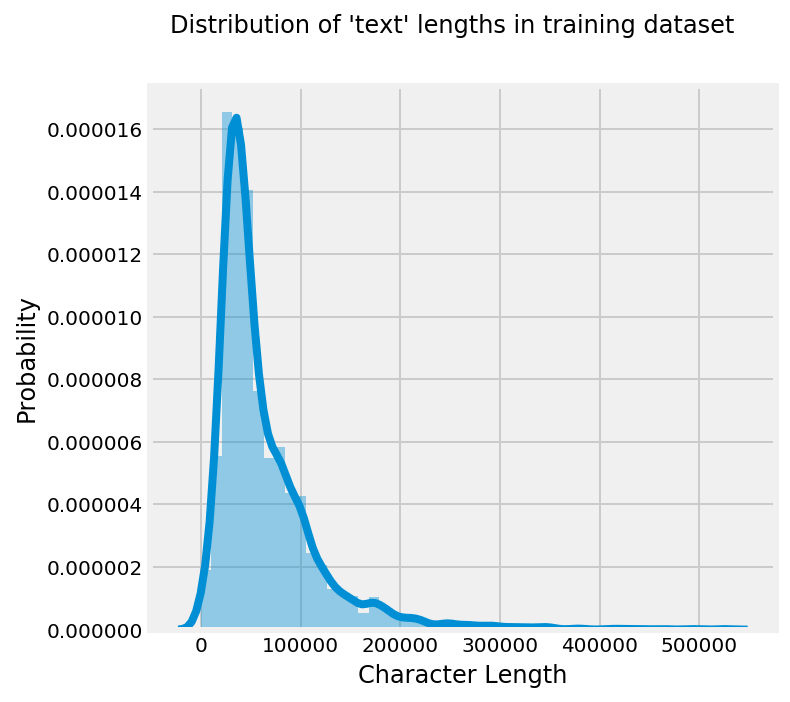

In [46]:
fig = plt.figure(figsize=(5,5))
sns.distplot(train['text'].str.len());
plt.suptitle("Distribution of 'text' lengths in training dataset")
plt.xlabel("Character Length")
plt.ylabel("Probability")
plt.show(fig)

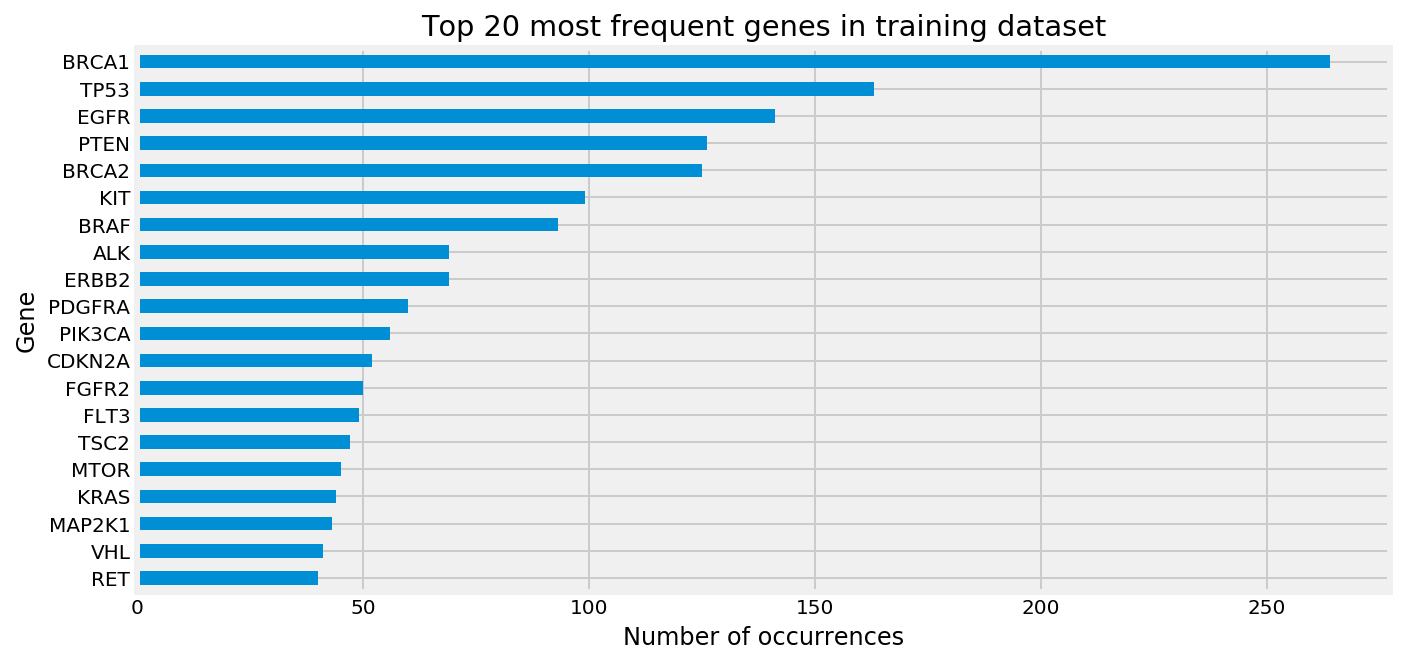

In [47]:
fig = plt.figure(figsize=(10,5))
plt.title('Top 20 most frequent genes in training dataset');
plt.xlabel("Number of occurrences")
plt.ylabel("Gene")
train['gene'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

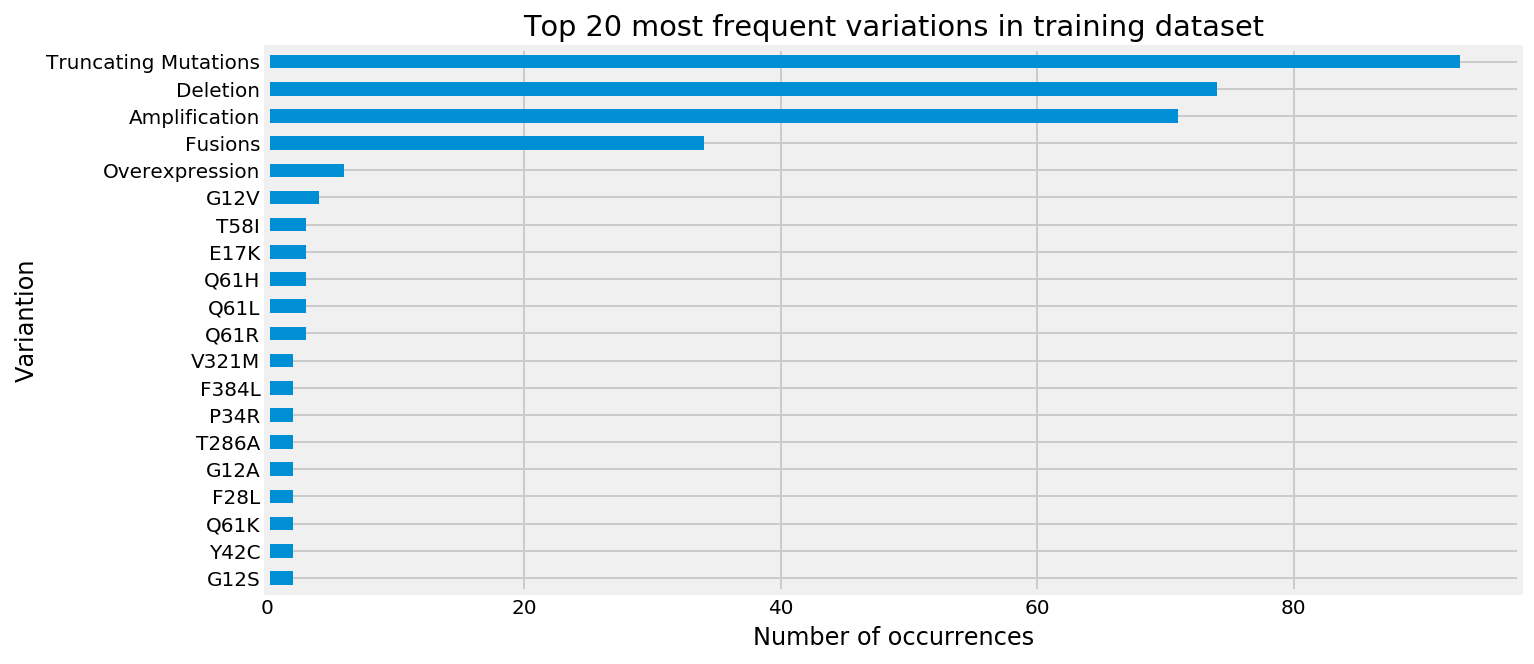

In [48]:
fig = plt.figure(figsize=(10,5))
plt.title('Top 20 most frequent variations in training dataset');
plt.xlabel("Number of occurrences")
plt.ylabel("Variantion")
train['variation'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

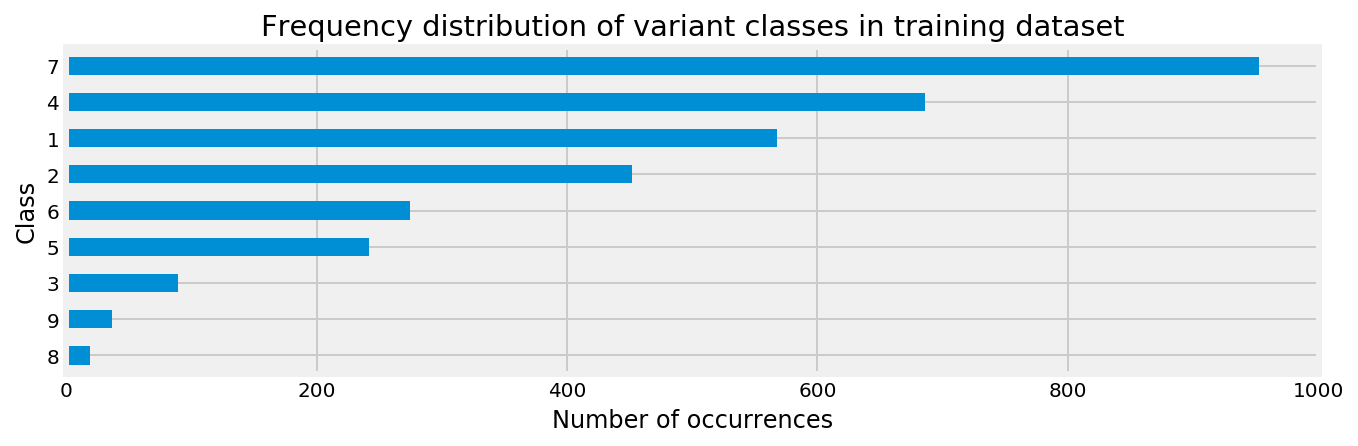

In [49]:
fig = plt.figure(figsize=(10,3))
plt.title('Frequency distribution of variant classes in training dataset');
plt.xlabel("Number of occurrences")
plt.ylabel("Class")
train['class'].value_counts().sort_values(ascending=True).plot(kind='barh');
plt.show(fig)

We note above that the **training set is highly imbalanced** -- i.e. classes 4 and 7 alone take up almost 50% of all classes found in the training set. We will need to deal with this when we fit the various candidate classifiers.

### Baseline Accuracy

We need to calculate baseline accuracy in order to tell if our model is outperforming the null model (predicting the majority class).

In [50]:
train['class'].value_counts(normalize=True)

7    0.286962
4    0.206564
1    0.171033
2    0.136104
6    0.082806
5    0.072870
3    0.026799
9    0.011141
8    0.005721
Name: class, dtype: float64

The proportion of the data points having the 'class' of 7 (i.e. **0.286962**) serves as our baseline (y-mean) statistic. Any model we create should not perform worse than this statistic.

## Data Export

We now export the cleaned training and testing datasets.

In [51]:
train.shape, test.shape

((3321, 5), (5668, 4))

In [52]:
# write out the csv files for subsequent pre-processing
train.to_csv("../datasets/train_clean.csv", index=False)
test.to_csv("../datasets/test_clean.csv", index=False)